## LIME Code from Scratch

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Explanation for instance: [[6.1 2.8 4.7 1.2]]
Feature sepal length (cm): Weight = -0.0424
Feature petal length (cm): Weight = -0.7033


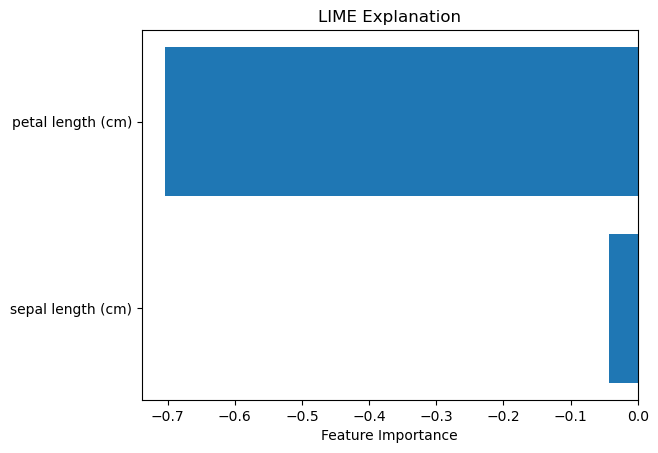

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

# Load the dataset
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Train a black-box model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Define the LIME function
class LIME:
    def __init__(self, black_box_model, kernel_width=0.75):
        self.model = black_box_model
        self.kernel_width = kernel_width
    
    def _kernel(self, distances):
        return np.sqrt(np.exp(-(distances ** 2) / self.kernel_width ** 2))
    
    def explain(self, instance, num_samples=500, num_features=2):
        # Step 1: Generate perturbed samples
        perturbed_samples = np.random.normal(loc=instance, scale=0.1, size=(num_samples, len(instance)))
        
        # Step 2: Get predictions for the perturbed samples
        predictions = self.model.predict_proba(perturbed_samples)
        
        # Step 3: Compute distances from the original instance
        distances = euclidean_distances(perturbed_samples, instance.reshape(1, -1)).flatten()
        weights = self._kernel(distances)
        
        # Step 4: Fit a local interpretable model
        interpretable_model = Ridge(alpha=1, fit_intercept=True)
        interpretable_model.fit(perturbed_samples, predictions[:, 1], sample_weight=weights)
        
        # Get the feature weights
        feature_weights = interpretable_model.coef_
        
        # Step 5: Identify the top features
        top_features = np.argsort(np.abs(feature_weights))[-num_features:]
        
        return {
            "instance": instance,
            "feature_weights": feature_weights,
            "top_features": top_features,
        }

# Instantiate LIME
lime = LIME(black_box_model=model)

# Select an instance to explain
instance = X_test.iloc[0].values.reshape(1, -1)

# Generate an explanation
explanation = lime.explain(instance.flatten(), num_samples=1000, num_features=2)

# Display the explanation
print("Explanation for instance:", instance)
for i, feature in enumerate(explanation['top_features']):
    print(f"Feature {X.columns[feature]}: Weight = {explanation['feature_weights'][feature]:.4f}")

# Visualization
top_features = explanation['top_features']
weights = explanation['feature_weights'][top_features]

plt.barh([X.columns[i] for i in top_features], weights)
plt.xlabel("Feature Importance")
plt.title("LIME Explanation")
plt.show()

c:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8946 - loss: 0.3674 - val_accuracy: 0.9808 - val_loss: 0.0736
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9801 - loss: 0.0646 - val_accuracy: 0.9847 - val_loss: 0.0581
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9877 - loss: 0.0400 - val_accuracy: 0.9835 - val_loss: 0.0595
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


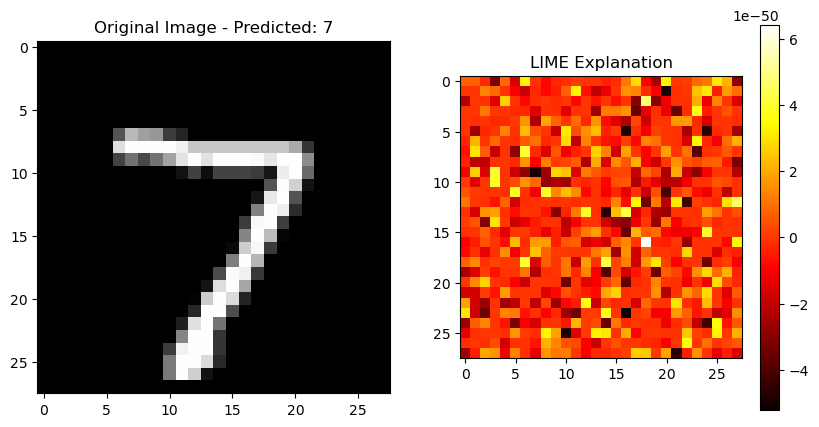

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import euclidean_distances

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0  # Normalize pixel values to [0, 1]
x_test = x_test / 255.0
x_train = x_train[..., np.newaxis]  # Add channel dimension
x_test = x_test[..., np.newaxis]

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=3, batch_size=64, verbose=1, validation_split=0.1)

# Define the LIME function
class LIME:
    def __init__(self, black_box_model, kernel_width=0.25):
        self.model = black_box_model
        self.kernel_width = kernel_width

    def _kernel(self, distances):
        return np.sqrt(np.exp(-(distances ** 2) / self.kernel_width ** 2))
    
    def explain(self, instance, num_samples=1000):
        """
        Explain the prediction for a given image instance.
        """
        # Step 1: Generate perturbed samples
        perturbed_samples = []
        for _ in range(num_samples):
            noise = np.random.normal(0, 0.2, instance.shape)
            perturbed_instance = np.clip(instance + noise, 0, 1)
            perturbed_samples.append(perturbed_instance)
        perturbed_samples = np.array(perturbed_samples)

        # Step 2: Get predictions for the perturbed samples
        predictions = self.model.predict(perturbed_samples, verbose=0)

        # Step 3: Compute distances from the original instance
        distances = euclidean_distances(
            perturbed_samples.reshape(num_samples, -1), 
            instance.reshape(1, -1)
        ).flatten()
        weights = self._kernel(distances)

        # Step 4: Fit a local interpretable model
        original_prediction_class = np.argmax(self.model.predict(instance[np.newaxis, ...], verbose=0))
        flattened_samples = perturbed_samples.reshape(num_samples, -1)
        interpretable_model = Ridge(alpha=1.0)
        interpretable_model.fit(flattened_samples, predictions[:, original_prediction_class], sample_weight=weights)

        # Get the feature weights (reshape them to the image shape)
        feature_weights = interpretable_model.coef_.reshape(instance.shape)
        return feature_weights

# Test the LIME explanation on an image
lime = LIME(black_box_model=model)

# Select an image from the test set
instance = x_test[0]
instance_label = np.argmax(model.predict(instance[np.newaxis, ...]), axis=1)[0]

# Generate an explanation
explanation = lime.explain(instance, num_samples=1000)

# Visualize the explanation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Original Image - Predicted: {instance_label}")
plt.imshow(instance.squeeze(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("LIME Explanation")
plt.imshow(explanation.squeeze(), cmap='hot')
plt.colorbar()
plt.show()
